# Importamos la librerías

In [1]:
#!/usr/bin/env python
  
"""
Ejemplo en PyTorch Red Generativa Antagonica (GAN).
Adaptado: https://medium.com/@devnag/generative-adversarial-
networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f#.sch4xgsa9
"""

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

matplotlib_is_available = True
try:
    from matplotlib import pyplot as plt
except ImportError:
    print("matplotlib no se encuentra disponible, no se mostrara el gráfico.")
    matplotlib_is_available = False

# Definimos la configuracion inicial

In [2]:
# Parametros de Datos
data_mean = 4
data_stddev = 1.25

# Descomente solo uno de estos para definir qué datos se envían 
# realmente al Discriminador.
""" 
nombre = "Datos en bruto"
preproceso = lambda datos: datos
d_func_entrada = lambda x: x
"""
"""
nombre = "Datos y variaciones"
preproceso = lambda datos: decorar_diferencias(datos, 2.0)
d_func_entrada = lambda x: x * 2
"""
"""
nombre = "Datos y diferencias"
preproceso = lambda datos: decorar_diferencias(datos, 1.0)
d_func_entrada = lambda x: x * 2
"""
nombre = "Solo los primeros 4 momentos"
preproceso = lambda datos: get_momentos(datos)
d_func_entrada = lambda x: 4

print("Data que se usara [%s]" % (nombre))

Data que se usara [Solo los primeros 4 momentos]


# Definimos los metodos de los datos que se utilizaran

In [3]:
# DATOS: Datos objetivo y datos de entrada del generador.
def get_muestra_de_distribucion(mu, sigma):
    # Gaussian
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))  

def get_muestra_entrada_de_distribucion():
    # Datos uniformes de dist en el generador, _NOT_ Gaussian
    return lambda m, n: torch.rand(m, n)  

# Definimos el modelo

In [4]:
# ##### Modelos: Generador y Discriminador.

class Generador(nn.Module):
    def __init__(self, tam_entrada, tam_oculta, tam_salida, func_act):
        super(Generador, self).__init__()
        self.map1 = nn.Linear(tam_entrada, tam_oculta)
        self.map2 = nn.Linear(tam_oculta, tam_oculta)
        self.map3 = nn.Linear(tam_oculta, tam_salida)
        self.f = func_act

    def forward(self, x):
        x = self.map1(x)
        x = self.f(x)
        x = self.map2(x)
        x = self.f(x)
        x = self.map3(x)
        return x

class Discriminador(nn.Module):
    def __init__(self, tam_entrada, tam_oculta, tam_salida, func_act):
        super(Discriminador, self).__init__()
        self.map1 = nn.Linear(tam_entrada, tam_oculta)
        self.map2 = nn.Linear(tam_oculta, tam_oculta)
        self.map3 = nn.Linear(tam_oculta, tam_salida)
        self.f = func_act

    def forward(self, x):
        x = self.f(self.map1(x))
        x = self.f(self.map2(x))
        return self.f(self.map3(x))

# Definimos los metodos de muestra de datos

In [5]:
def extracto(v):
    return v.data.storage().tolist()

def estado(d):
    return [np.mean(d), np.std(d)]

# Definimos los métodos de obtención de datos

In [6]:
def get_momentos(d):
    # Devuelve los primeros 4 momentos de los datos proporcionados.
    mean = torch.mean(d)
    diffs = d - mean
    var = torch.mean(torch.pow(diffs, 2.0))
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0))

    # exceso de kurtosis, debe ser 0 para gaussiano.
    kurtoses = torch.mean(torch.pow(zscores, 4.0)) - 3.0

    final = torch.cat((mean.reshape(1,), 
                        std.reshape(1,), 
                        skews.reshape(1,), 
                        kurtoses.reshape(1,))
                    )
    return final

def decorar_diferencias(data, exponent, remove_raw_data=False):
    mean = torch.mean(data.data, 1, keepdim=True)
    mean_broadcast = torch.mul(torch.ones(data.size()), mean.tolist()[0][0])
    diffs = torch.pow(data - Variable(mean_broadcast), exponent)
    if remove_raw_data:
        return torch.cat([diffs], 1)
    else:
        return torch.cat([data, diffs], 1)

# Metodo de entrenamiento de la red y graficación

In [7]:
def train():
    # Parametros para los modelos. 
    # G o g ----> Generador
    # D o d ----> Discriminador
    g_tam_entrada = 1       # Tam. del vector entrada del generador.
    g_tam_oculta = 5        # Numeros de capaz ocultas del generador.
    g_tam_salida = 1        # Tam. del vector salida del generador.
    d_tam_entrada = 500     # Tam. del vector entrada del discriminador.
    d_tam_oculta = 10       # Numeros de capaz ocultas del discriminador.
    d_tam_salida = 1        # Determina clasificación 'real' vs. 'falsa'
    minibatch_size = d_tam_entrada  # Tam. de minibatch - cardinalidad de dist.

    d_tasa_aprend = 1e-3
    g_tasa_aprend = 1e-3
    sgd_momentum = 0.9

    num_epochs = 5000
    intervalos_impresion = 1000
    d_pasos = 20
    g_pasos = 20

    dfe, dre, ge = 0, 0, 0
    d_datos_reales, d_data_falsa, g_data_falsa = None, None, None

    discriminador_func_activacion = torch.sigmoid
    generador_func_activacion = torch.tanh

    d_muestra = get_muestra_de_distribucion(data_mean, data_stddev)
    g_muestra_entrada = get_muestra_entrada_de_distribucion()

    G = Generador(tam_entrada=g_tam_entrada,
                  tam_oculta=g_tam_oculta,
                  tam_salida=g_tam_salida,
                  func_act=generador_func_activacion)
    
    D = Discriminador(tam_entrada=d_func_entrada(d_tam_entrada),
                      tam_oculta=d_tam_oculta,
                      tam_salida=d_tam_salida,
                      func_act=discriminador_func_activacion)
    
    # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
    criterio = nn.BCELoss()  
    
    d_optimizador = optim.SGD(D.parameters(), 
                              lr=d_tasa_aprend, 
                              momentum=sgd_momentum)
    g_optimizador = optim.SGD(G.parameters(), 
                              lr=g_tasa_aprend, 
                              momentum=sgd_momentum)

    for epoch in range(num_epochs):
        for d_index in range(d_pasos):
            # 1. Entrenar D con real+falsa
            D.zero_grad()

            #  1A: Entrenar D con real
            d_datos_reales = Variable(d_muestra(d_tam_entrada))
            d_decision_real = D(preproceso(d_datos_reales))
            # Uno = true
            d_error_real = criterio(d_decision_real, Variable(torch.ones([1])))  
            # Calculo de gradientes, Pero sin cambio de parametros 
            d_error_real.backward() 

            #  1B: Entrenar D con falsa
            d_entrada_g = Variable(g_muestra_entrada(minibatch_size, g_tam_entrada))
            # Desprenderse para evitar entrenar a G en estas etiquetas.
            d_data_falsa = G(d_entrada_g).detach()  
            d_decision_falsa = D(preproceso(d_data_falsa.t()))
            # Cero = False
            d_error_falso = criterio(d_decision_falsa, Variable(torch.zeros([1])))  
            d_error_falso.backward()
            
            # Solo optimiza los parámetros de D; 
            # cambios basados en gradientes almacenados de backward()
            d_optimizador.step()     

            dre, dfe = extracto(d_error_real)[0], extracto(d_error_falso)[0]

        for g_index in range(g_pasos):
            # 2. Entrenar G con la respuesta de D (Pero no con las etiquetas de D)
            G.zero_grad()

            entrada_g = Variable(g_muestra_entrada(minibatch_size, g_tam_entrada))
            g_data_falsa = G(entrada_g)
            dg_decision_falsa = D(preproceso(g_data_falsa.t()))

            # Entrenar G pretendiendo que es genuino
            g_error = criterio(dg_decision_falsa, Variable(torch.ones([1])))  

            g_error.backward()
            g_optimizador.step()  # Optimizar solo parametros de G
            ge = extracto(g_error)[0]

        if epoch % intervalos_impresion == 0:
            print("""Epoch %s: D (%s error_real, %s error_falso)
            G (%s error);
            Dist Real (%s),
            Dist Falsa (%s)""" %
                  (epoch, dre, dfe, 
                   ge, 
                   estado(extracto(d_datos_reales)), 
                   estado(extracto(d_data_falsa))))

    if matplotlib_is_available:
        print("Graficando Distribucion generada...")
        values = extracto(g_data_falsa)
        #print(" Valores: %s" % (str(values)))
        plt.hist(values, bins=50)
        plt.xlabel('Valores')
        plt.ylabel('Cantidad')
        plt.title('Histograma de Distribucion Generada')
        plt.grid(True)
        plt.show()

# Menu principal

Epoch 0: D (0.6006104946136475 error_real, 0.7964677214622498 error_falso)
            G (0.6009078621864319 error);
            Dist Real ([3.986403957366943, 1.2583828840606366]),
            Dist Falsa ([-0.15931420877575875, 0.010723767704693661])
Epoch 1000: D (0.6831129193305969 error_real, 0.6997002959251404 error_falso)
            G (0.6932072639465332 error);
            Dist Real ([4.023943076461554, 1.2723253756304074]),
            Dist Falsa ([4.000200130462646, 1.3638218200651904])
Epoch 2000: D (0.7070448994636536 error_real, 0.6926671266555786 error_falso)
            G (0.6952601671218872 error);
            Dist Real ([3.97329869556427, 1.2461586461715577]),
            Dist Falsa ([3.985973516225815, 1.3420971032692766])
Epoch 3000: D (0.6919887661933899 error_real, 0.6913560032844543 error_falso)
            G (0.6894882917404175 error);
            Dist Real ([4.112150792479515, 1.2782857104125396]),
            Dist Falsa ([4.017712101936341, 1.2052934523529384])

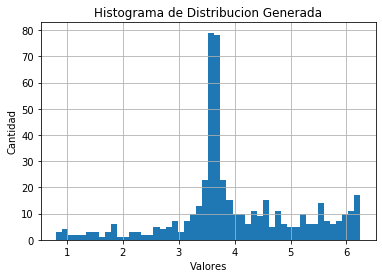

In [8]:
if __name__ == "__main__":
    train()